# 17. 오토인코더, GAN 그리고 확산 모델

In [1]:
# 공통 모듈 임포트
import numpy as np
import tensorflow as tf
import os

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

## 17.1 효율적인 데이터 표현

## 17.2 과소완전 선형 오토인코더로 PCA 수행하기

In [3]:
encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss = 'mse', optimizer=optimizer)

2023-11-19 15:23:26.843733: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-19 15:23:26.843797: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-11-19 15:23:26.843819: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-11-19 15:23:26.843875: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-19 15:23:26.843913: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # 고르지 않은 분포
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # 타원형
X += 0.28 * np.random.randn(m, 3)  # 노이즈 추가
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # 약간 이동

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose = False)
codings = encoder.predict(X_train)

2023-11-19 15:28:41.992244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-11-19 15:28:42.009281: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp.


2/2 [==============================] - 0s 5ms/step


## 17.3 적층 오토인코더

### 17.3.1 케라스로 적층 오토인코더 구현하기

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [3]:
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu')
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss = 'mse', optimizer='nadam')
history = stacked_ae.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

2023-11-20 16:04:54.805003: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-20 16:04:54.805054: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-11-20 16:04:54.805491: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-11-20 16:04:54.805595: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-20 16:04:54.805953: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


2023-11-20 16:04:55.902533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1719/1719 [==============================] - 25s 14ms/step - loss: 0.0768 - val_loss: 1.4210
Epoch 2/20
1719/1719 [==============================] - 22s 13ms/step - loss: 0.1564 - val_loss: 0.0321
Epoch 3/20
1719/1719 [==============================] - 22s 13ms/step - loss: 0.1061 - val_loss: 0.0453
Epoch 4/20
1719/1719 [==============================] - 22s 13ms/step - loss: 0.2158 - val_loss: 0.0325
Epoch 5/20
1719/1719 [==============================] - 22s 13ms/step - loss: 0.1360 - val_loss: 0.0513
Epoch 6/20
1719/1719 [==============================] - 22s 13ms/step - loss: 0.1805 - val_loss: 0.1715
Epoch 7/20
1719/1719 [==============================] - 22s 13ms/step - loss: 0.1687 - val_loss: 0.0370
Epoch 8/20
1719/1719 [==============================] - 22s 13ms/step - loss: 0.1450 - val_loss: 0.0476
Epoch 9/20
1719/1719 [==============================] - 22s 13ms/step - loss: 0.2227 - val_loss: 0.0356
Epoch 10/20
1719/1719 [==============================] - 22s 13ms/step - lo

### 17.3.2 재구성 시각화

1/1 [==============================] - 0s 17ms/step


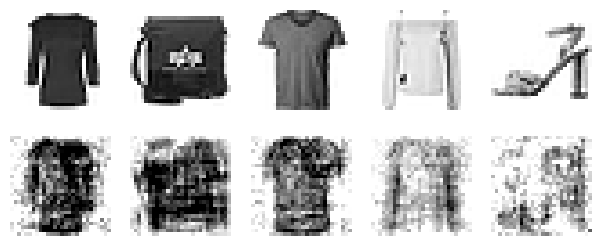

In [8]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize = (n_images * 1.5, 3))

    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap='binary')
        plt.axis('off')
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap='binary')
        plt.axis('off')

plot_reconstructions(stacked_ae)
plt.show()

### 17.3.3 패션 MNIST 데이터셋 시각화

In [9]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init='pca', learning_rate='auto', random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 1ms/step


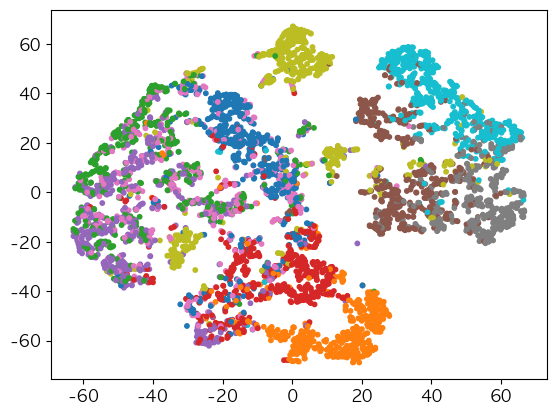

In [10]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap='tab10')
plt.show()

### 17.3.4 적층 오토인코더를 사용한 비지도 사전 훈련

### 17.3.5 가중치 묶기

In [11]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation = None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name = 'bias', shape = self.dense.input_shape[-1], initializer='zeros')
        super().build(batch_input_shape)
    
    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weigths[0], transpose_b=True)
        return self.activation(Z + self.biases)

In [12]:
dense_1 = tf.keras.layers.Dense(100, activation='relu')
dense_2 = tf.keras.layers.Dense(30, activation='relu')

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation='relu'),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28, 28])
])

tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])

### 17.3.6 오토인코더 한 개씩 훈련하기

## 17.4 합성곱 오토인코더

In [14]:
conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # 출력: 14 × 14 x 16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # 출력: 7 × 7 x 32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2),  # 출력: 3 × 3 x 64
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D()  # 출력: 30
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(3 * 3 * 16),
    tf.keras.layers.Reshape((3, 3, 16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same",
                                    activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28, 28])
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

## 17.5 잡음 제거 오토인코더

In [15]:
dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu')
])

dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])